In [1]:
import dlib, cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects

detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor('./models/shape_predictor_68_face_landmarks.dat')
facerec = dlib.face_recognition_model_v1('./models/dlib_face_recognition_resnet_model_v1.dat')

In [11]:
def find_faces(img):
    dets = detector(img, 1)

    if len(dets) == 0:
        return np.empty(0), np.empty(0), np.empty(0)
    
    rects, shapes = [], []
    shapes_np = np.zeros((len(dets), 68, 2), dtype=np.int)
    for k, d in enumerate(dets):
        rect = ((d.left(), d.top()), (d.right(), d.bottom()))
        rects.append(rect)

        shape = sp(img, d)
        
        # convert dlib shape to numpy array
        for i in range(0, 68):
            shapes_np[k][i] = (shape.part(i).x, shape.part(i).y)

        shapes.append(shape)
        
    return rects, shapes, shapes_np

def encode_faces(img, shapes):
    face_descriptors = []
    for shape in shapes:
        face_descriptor = facerec.compute_face_descriptor(img, shape)
        face_descriptors.append(np.array(face_descriptor))

    return np.array(face_descriptors)


# Compute Saved Face Descriptions

In [3]:
img_paths = {
    'neo': 'img/neo.jpg',
    'trinity': 'img/trinity.jpg',
    'morpheus': 'img/morpheus.jpg',
    'smith': 'img/smith.jpg'
}

descs = {
    'neo': None,
    'trinity': None,
    'morpheus': None,
    'smith': None
}

for name, img_path in img_paths.items():
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    #bgr을 rgb로 변경

    _, img_shapes, _ = find_faces(img_rgb)
    descs[name] = encode_faces(img_rgb, img_shapes)[0]

np.save('img/descs.npy', descs)
#숫자형식으로 변경
print(descs)

{'neo': array([-0.10253663,  0.1210689 ,  0.11573793,  0.00205042, -0.07788962,
        0.0455309 , -0.05843274, -0.0519091 ,  0.21658492,  0.01360174,
        0.22794811, -0.06277425, -0.24470335, -0.07928558,  0.06872851,
        0.08918308, -0.18241556, -0.12478449,  0.02782023, -0.0830949 ,
        0.07161663,  0.05966347,  0.00160632,  0.06678436, -0.21823257,
       -0.36267716, -0.06694743, -0.14702256,  0.04950852, -0.1844839 ,
       -0.0644467 ,  0.00363292, -0.21857822, -0.11856331,  0.02003656,
        0.11713767, -0.07477781, -0.09792066,  0.14710173, -0.01258704,
       -0.13804421,  0.02091832,  0.04052263,  0.22699335,  0.20785414,
        0.07426941, -0.01183021, -0.0786138 ,  0.14942402, -0.25231487,
        0.09901293,  0.22049414,  0.09498686,  0.09029035,  0.09735814,
       -0.15367737, -0.0305498 ,  0.14856222, -0.26968357,  0.10302345,
        0.08786085,  0.01532106,  0.04833578, -0.0422222 ,  0.13174652,
        0.09351434, -0.08683694, -0.11075915,  0.0428902

# Compute Input

In [12]:
img_bgr = cv2.imread('img/matrix.jpg')
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

rects, shapes, _ = find_faces(img_rgb)
descriptors = encode_faces(img_rgb, shapes)

TypeError: object of type 'dlib.full_object_detection' has no len()

# Visualize Output

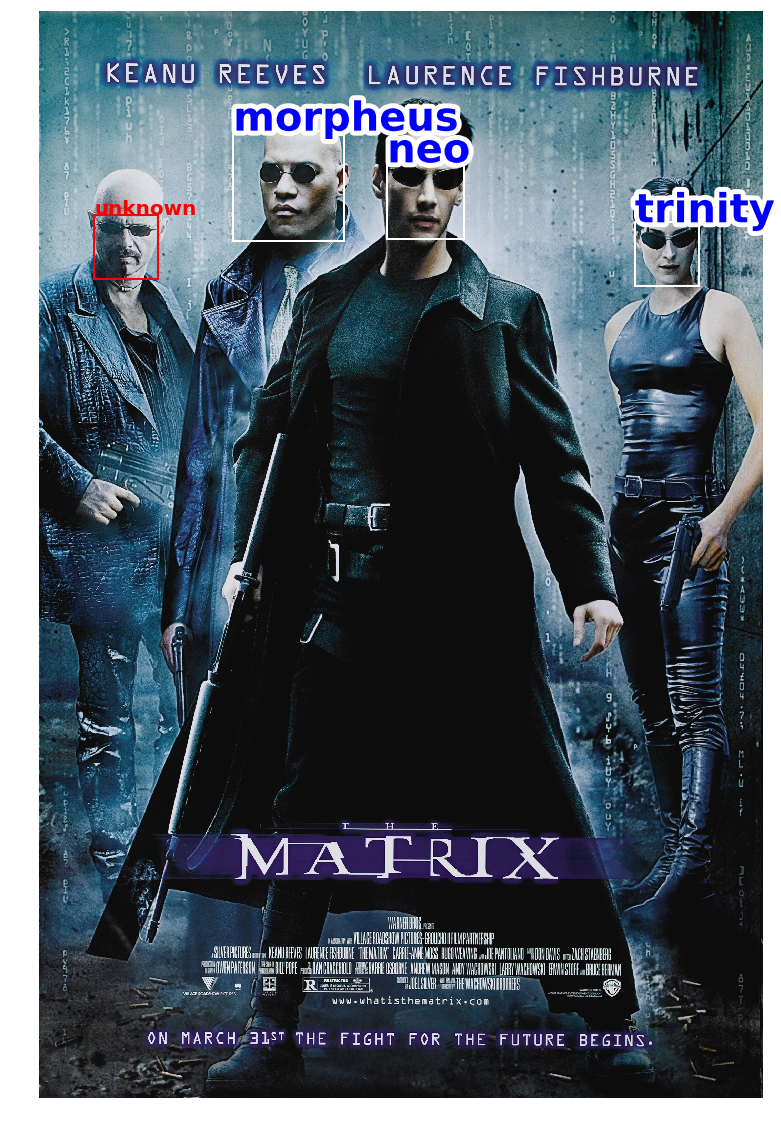

In [10]:
fig, ax = plt.subplots(1, figsize=(20, 20))
ax.imshow(img_rgb)

for i, desc in enumerate(descriptors):
    
    found = False
    for name, saved_desc in descs.items():
        dist = np.linalg.norm([desc] - saved_desc, axis=1)
        #a-b의 유클리드 거리를 구한다 

        if dist < 0.6:
            found = True

            text = ax.text(rects[i][0][0], rects[i][0][1], name,
                    color='b', fontsize=40, fontweight='bold')
            text.set_path_effects([path_effects.Stroke(linewidth=10, foreground='white'), path_effects.Normal()])
            rect = patches.Rectangle(rects[i][0],
                                 rects[i][1][1] - rects[i][0][1],
                                 rects[i][1][0] - rects[i][0][0],
                                 linewidth=2, edgecolor='w', facecolor='none')
            ax.add_patch(rect)

            break
    
    if not found:
        ax.text(rects[i][0][0], rects[i][0][1], 'unknown',
                color='r', fontsize=20, fontweight='bold')
        rect = patches.Rectangle(rects[i][0],
                             rects[i][1][1] - rects[i][0][1],
                             rects[i][1][0] - rects[i][0][0],
                             linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

plt.axis('off')
plt.savefig('result/output.png')
plt.show()